In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error , r2_score, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import (cross_val_score, train_test_split, cross_val_score, 
                                     RandomizedSearchCV, GridSearchCV, StratifiedKFold)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier        # Requires installation of the package ; Not a native function in sklearn
from lightgbm import LGBMClassifier      # Requires installation of the package; Not a native function in sklearn
from catboost import CatBoostClassifier 

# Creating a list of colors based on the "tab10" colormap.
# I like the color set in the "tab10" colormap.
cmap = plt.colormaps["tab10"]
colors = [cmap(i) for i in range(21)]

# Different Marker for Scatter plot
markers = ['o', 's', '*', 'x', '^', 'v', '<', '>']  # Different markers for different classes

In [2]:
from utils.notebook_config import *
# Download latest version
file_path = "dataset/synthetic_coffee_health_10000.csv"

# Load the latest version
data = pd.read_csv(file_path)

print(data.head())

# Apply label encoding to categorical column
label_encoder = LabelEncoder()

non_number = data.select_dtypes(exclude=["number"]).columns

for i in non_number:
    print(i)
    data[i] = label_encoder.fit_transform(data[i])

train_df, val_df = train_test_split(data, test_size=0.3, random_state=42)

   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consumption  
0           NaN      Other        0                    0 

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_63768/2389977454.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


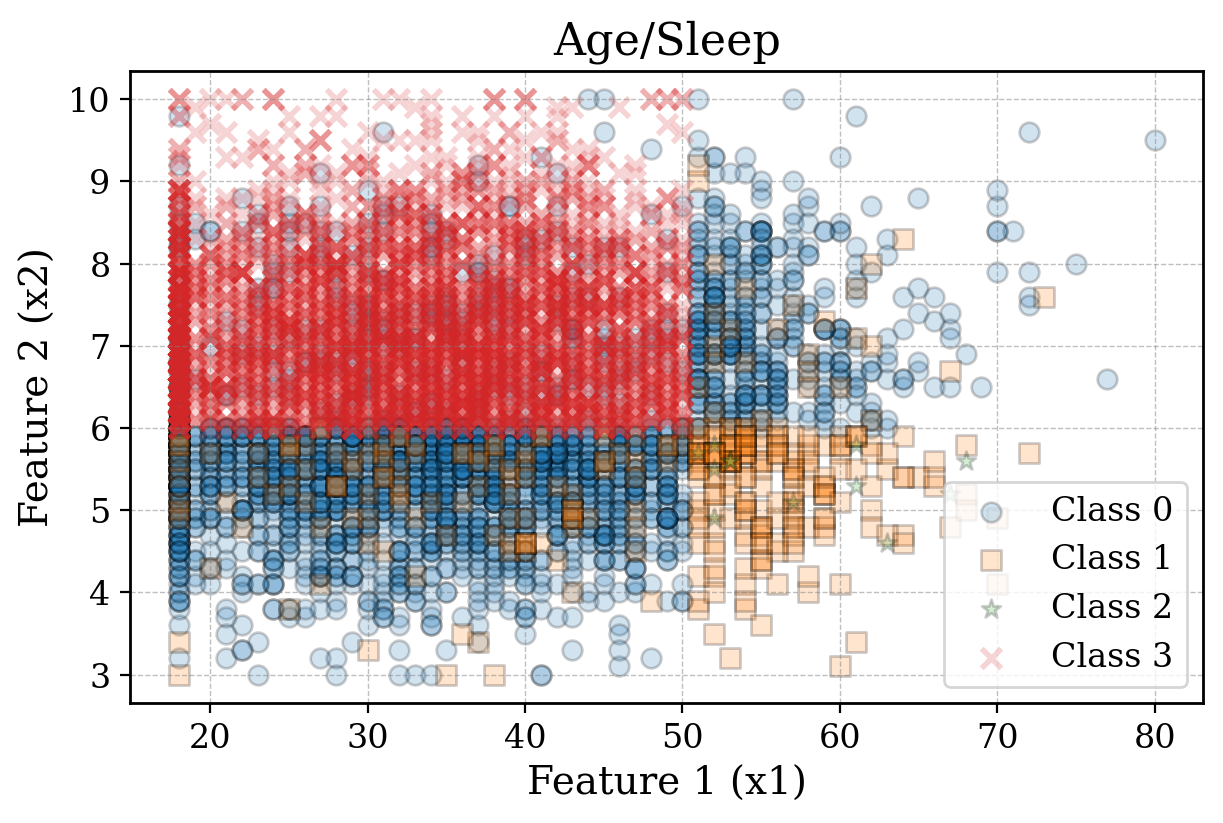

In [3]:
X_train = train_df[["Age","Sleep_Hours"]].to_numpy()
y_train = train_df["Health_Issues"].to_numpy()

def visualize_data(x, y, title):
    plt.figure()
    
    classes = np.unique(y) # Get unique class labels

    for i, label in enumerate(classes):
        plt.scatter(
            x[y == label, 0],
            x[y == label, 1],
            marker=markers[i % len(markers)],
            color=colors[i], edgecolor="k" ,
            s=50, alpha=0.2, 
            label=f"Class {label}")

    plt.xlabel("Feature 1 (x1)")
    plt.ylabel("Feature 2 (x2)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_data(X_train,y_train,"Age/Sleep")

In [4]:
#start with the visualization
#smoking and alcohol are boolean
#Gender Country and Sleep quality must be converted to numerals
"""Country could be hard to convert maybe we just sort them by GDP and give them descending numbers based on that or we use an index measuring health care. Coffee intake and estimated caffeine is redundent """
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  int64  
 3   Country                  10000 non-null  int64  
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  int64  
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  int64  
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            10000 non-null  int64  
 13  Occupation               10000 non-null  int64  
 14  Smoking                

ID           Age        Gender       Country  Coffee_Intake  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000     34.949100      0.522500      9.466800       2.509230   
std     2886.89568     11.160939      0.542884      5.740086       1.450248   
min        1.00000     18.000000      0.000000      0.000000       0.000000   
25%     2500.75000     26.000000      0.000000      4.000000       1.500000   
50%     5000.50000     34.000000      0.000000      9.000000       2.500000   
75%     7500.25000     43.000000      1.000000     14.000000       3.500000   
max    10000.00000     80.000000      2.000000     19.000000       8.200000   

        Caffeine_mg   Sleep_Hours  Sleep_Quality           BMI    Heart_Rate  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean     238.411010      6.636220       1.620700     23.986860     70.617800   
std      137.748815      1.222055       0.835525      3.906411      9.822951   
min        0.000000      3.000000       0.000000     15.000000     50.000000   
25%      138.750000      5.800000       1.000000     21.300000     64.000000   
50%      235.400000      6.600000       2.000000     24.000000     71.000000   
75%      332.025000      7.500000       2.000000     26.600000     77.000000   
max      780.300000     10.000000       3.000000     38.200000    109.000000   

       Stress_Level  Physical_Activity_Hours  Health_Issues   Occupation  \
count  10000.000000              10000.00000   10000.000000  10000.00000   
mean       1.108900                  7.48704       1.832000      1.98920   
std        0.537838                  4.31518       1.429678      1.40566   
min        0.000000                  0.00000       0.000000      0.00000   
25%        1.000000                  3.70000       0.000000      1.00000   
50%        1.000000                  7.50000       3.000000      2.00000   
75%        1.000000                 11.20000       3.000000      3.00000   
max        2.000000                 15.00000       3.000000      4.00000   

           Smoking  Alcohol_Consumption  
count  10000.00000         10000.000000  
mean       0.20040             0.300700  
std        0.40032             0.458585  
min        0.00000             0.000000  
25%        0.00000             0.000000  
50%        0.00000             0.000000  
75%        0.00000             1.000000  
max        1.00000             1.000000

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_63768/2198168833.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


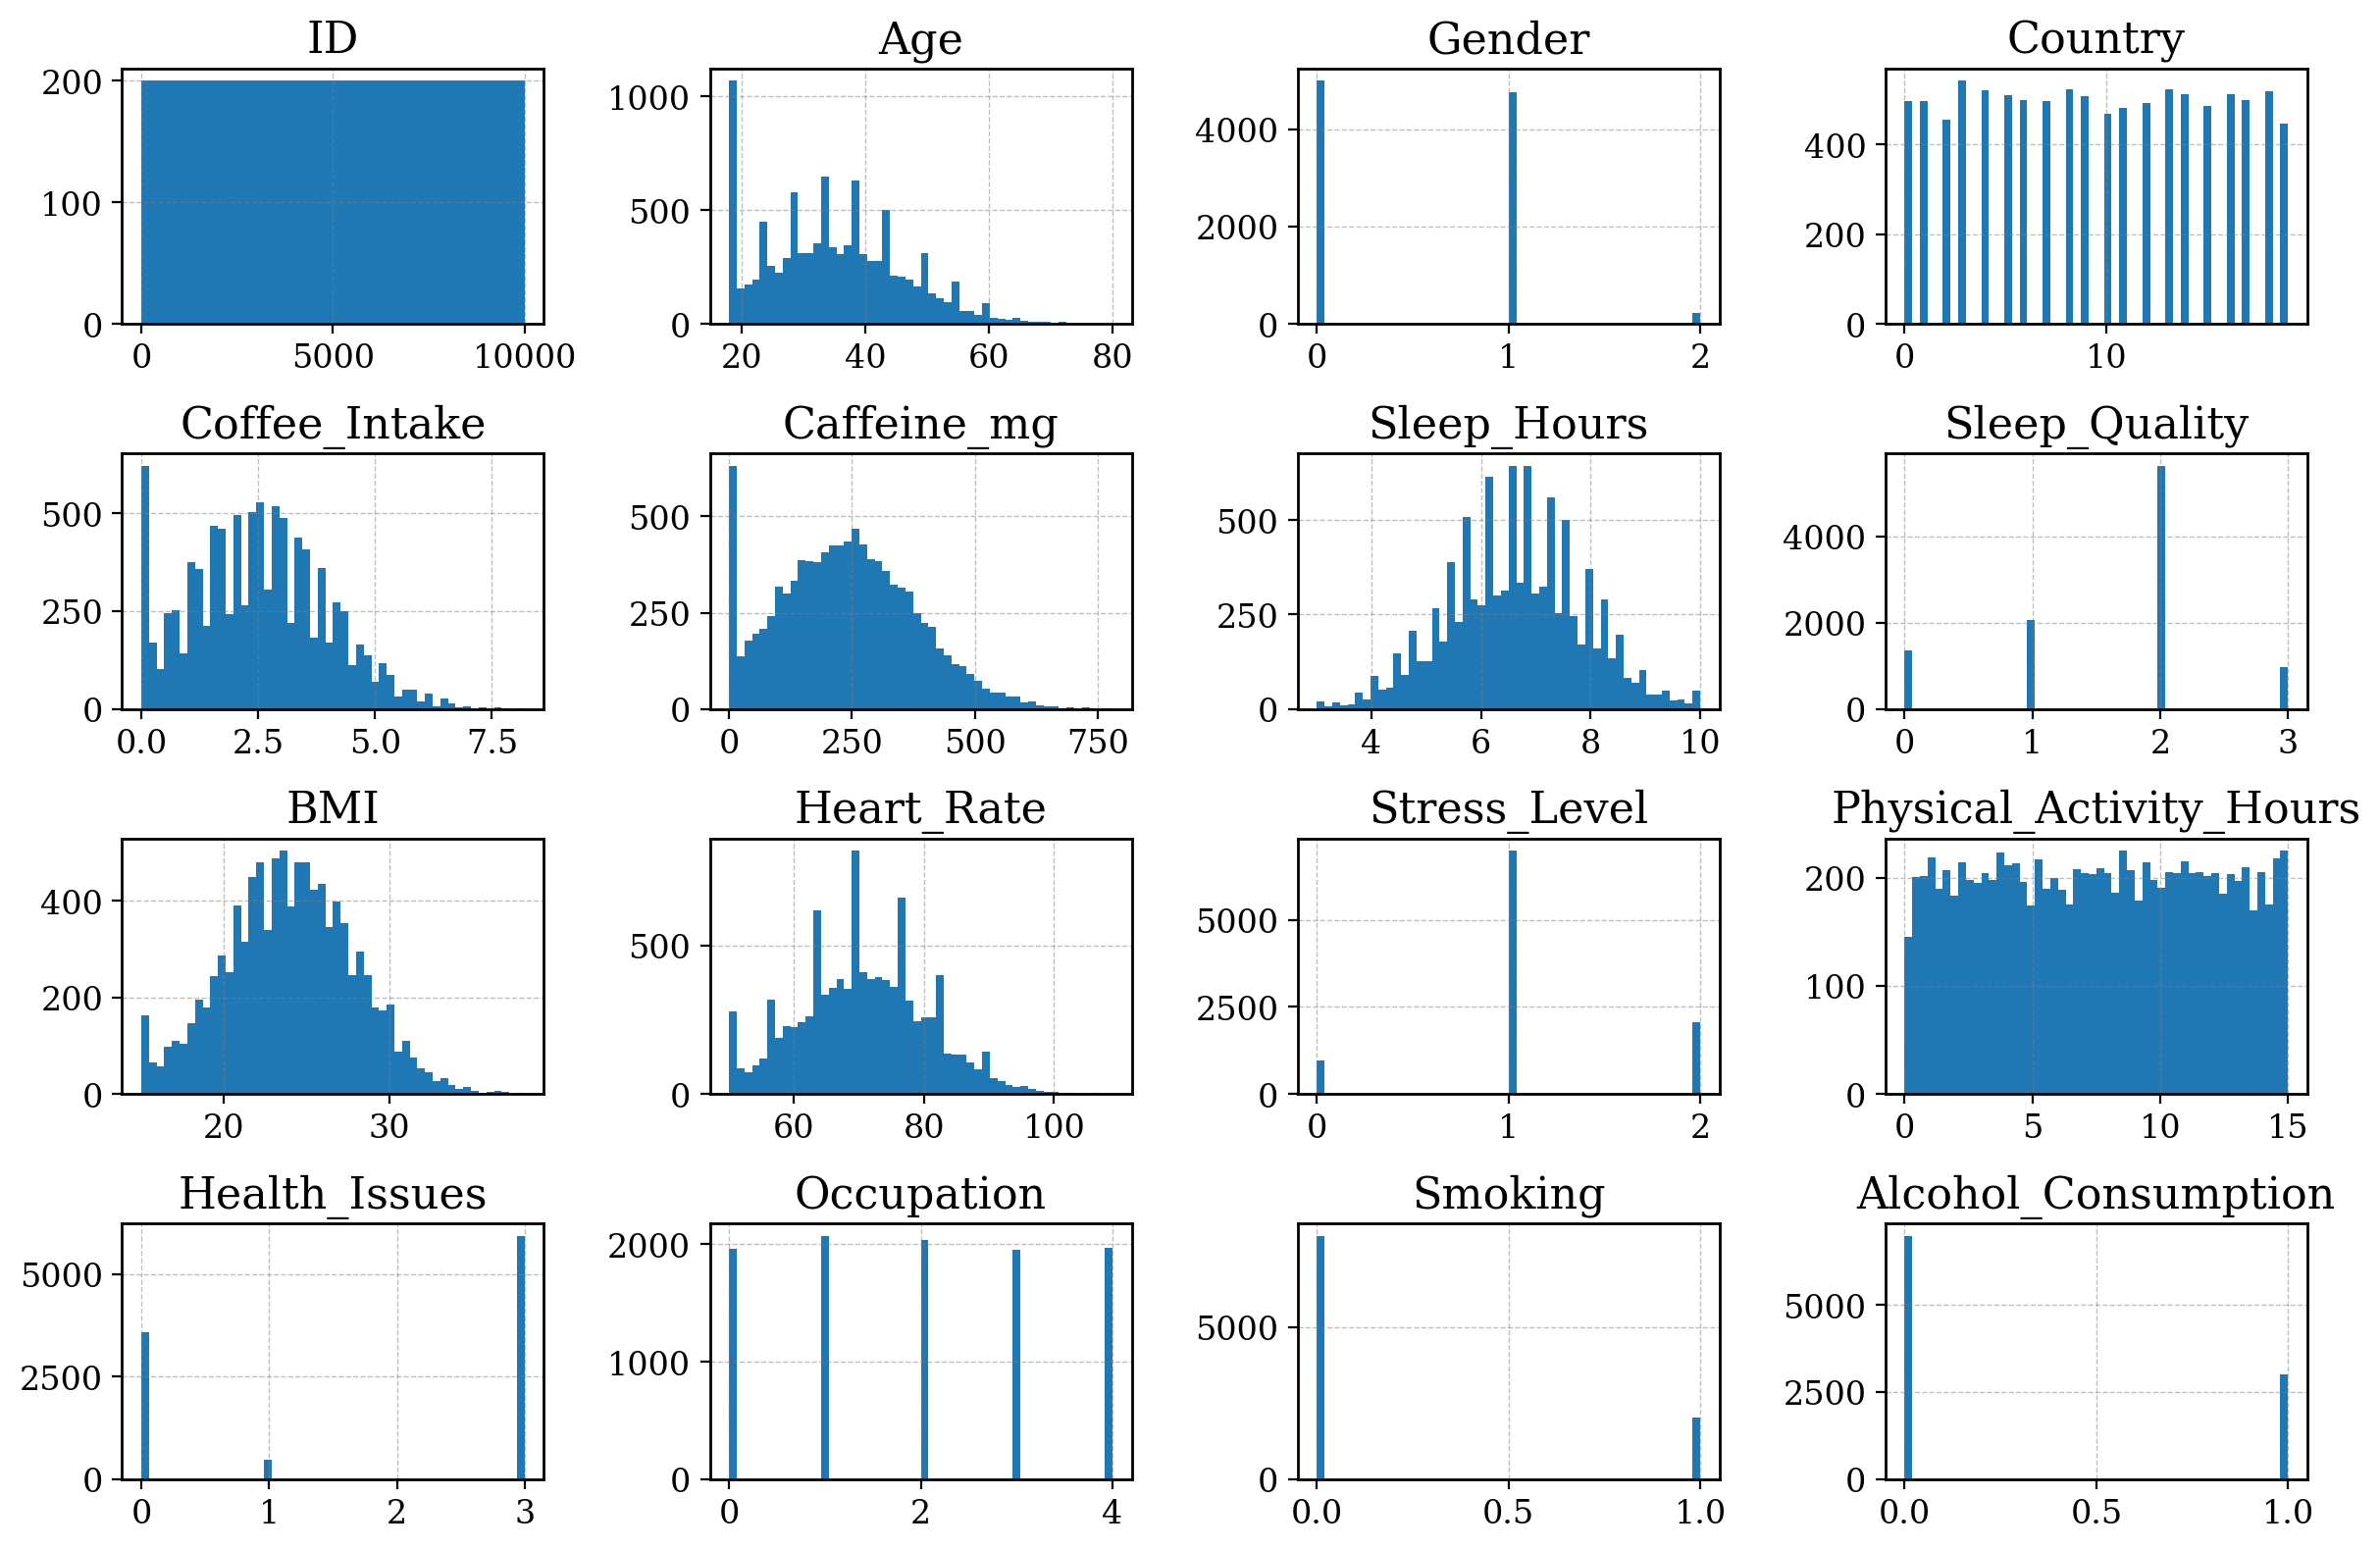

In [5]:
data.hist(bins=50, figsize=(12, 8))
plt.tight_layout()

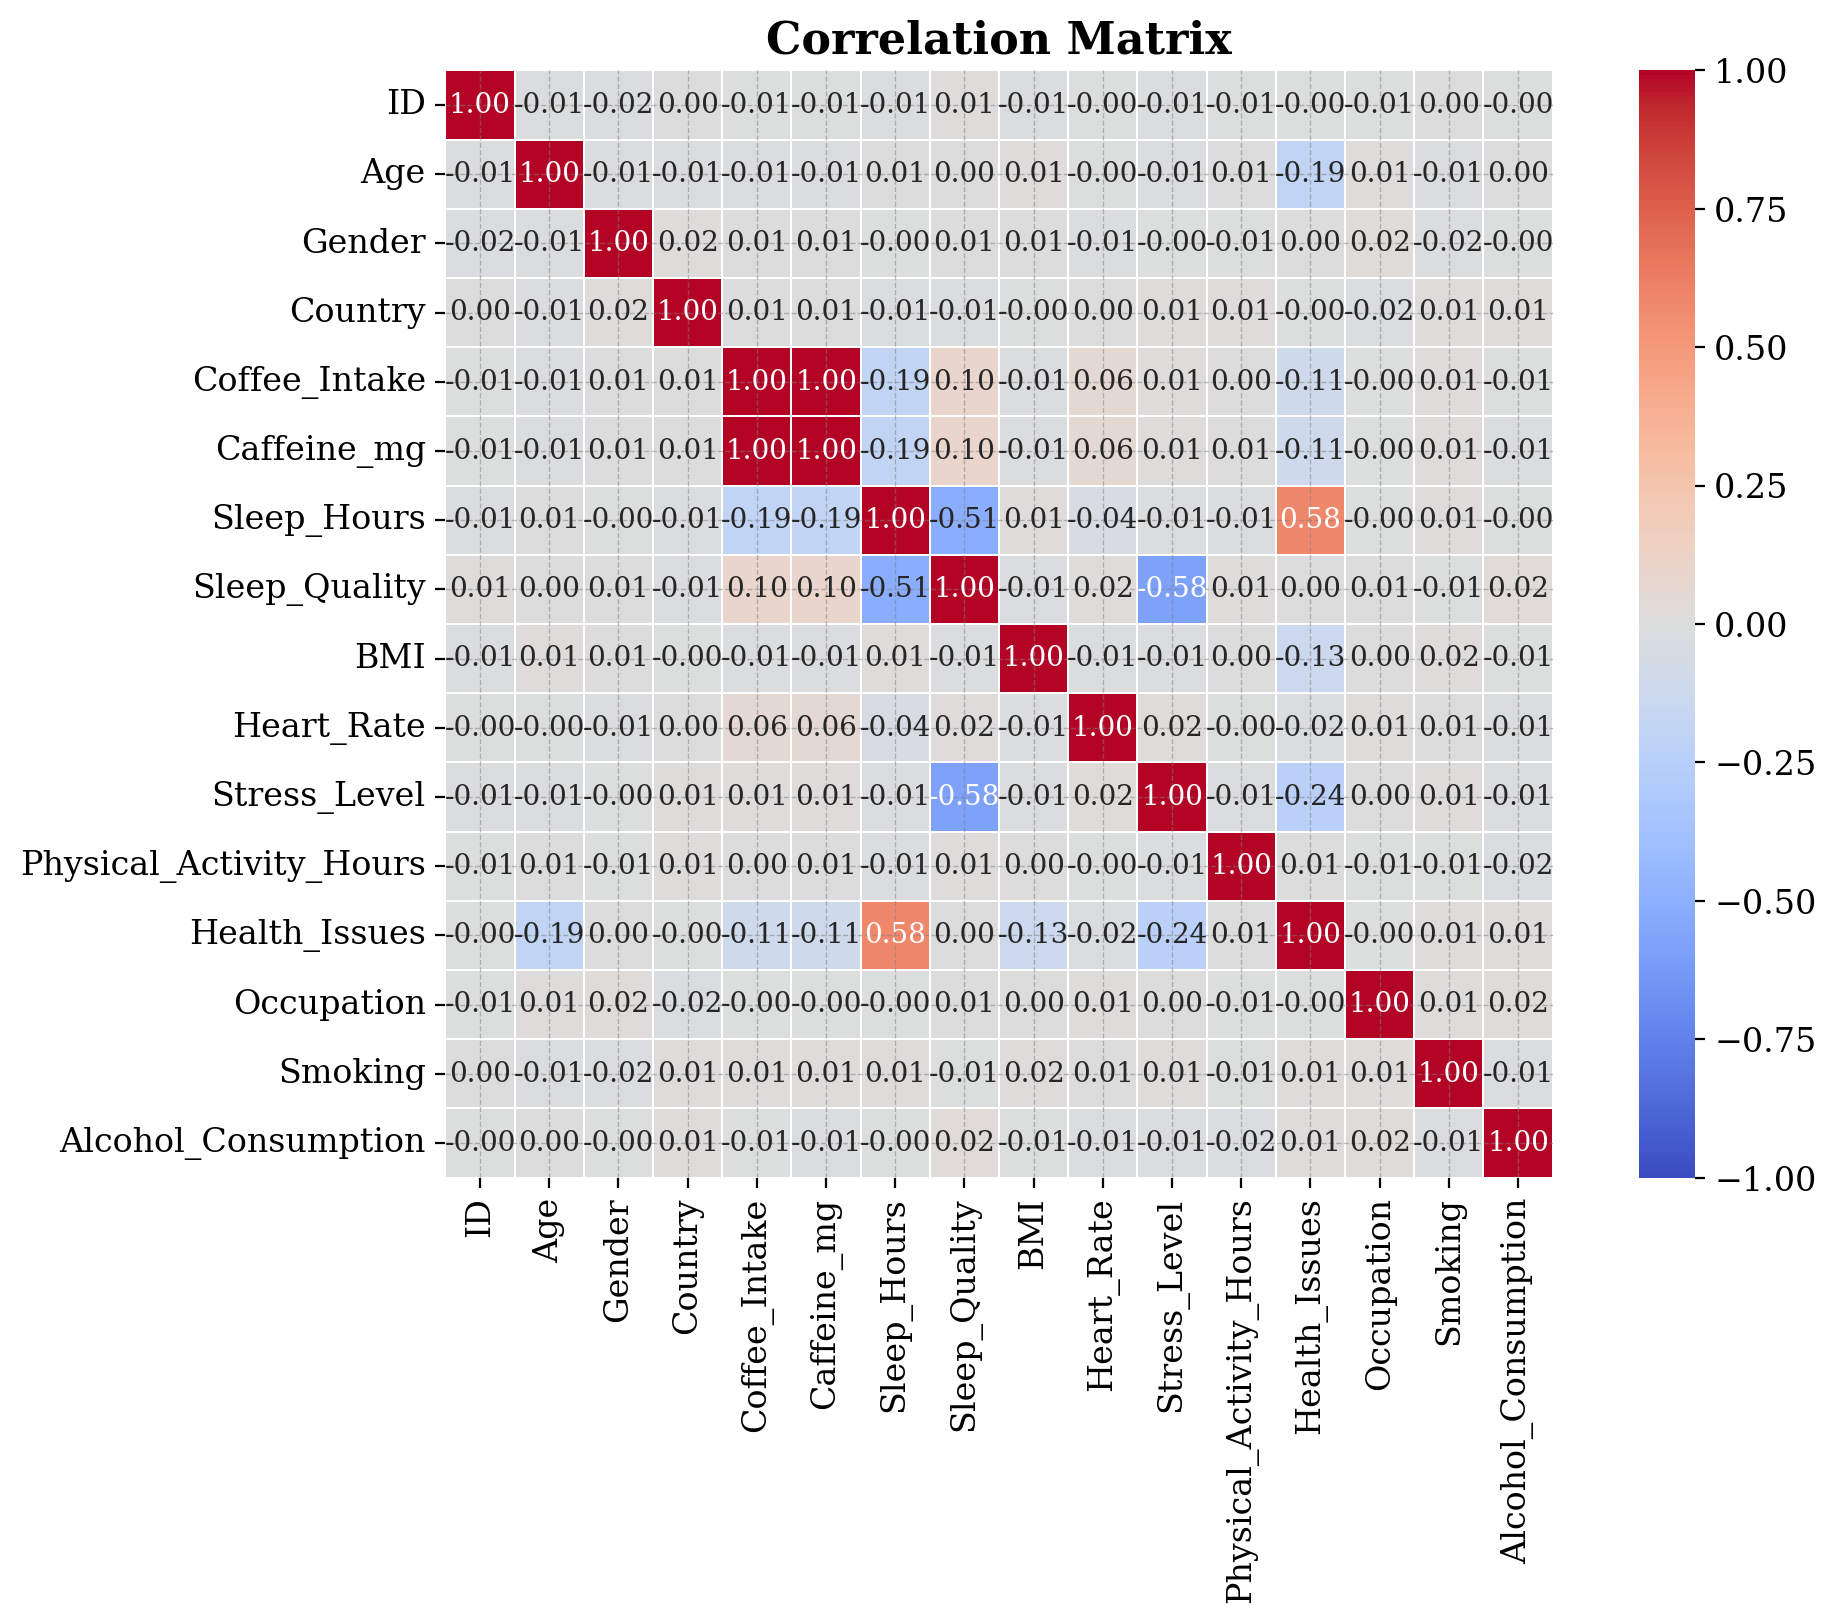

In [6]:
corr = data.corr(numeric_only=True)

#sns.set(font_scale=0.8, font="serif")
# Show heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(corr,
            annot=True, fmt=".2f",
            vmax=1.0, vmin=-1.0,
            linewidths=0.1,
            cmap="coolwarm",
            square=True, cbar=True)
plt.title("Correlation Matrix", fontweight="bold")
#plt.tight_layout()
plt.savefig("corr_matrix.png")
plt.show()

Based on the correlation matrix, we can drop the features "Occupation", "Gender", "Country", "Alcohol", "Smoking" and "Physical Activity", since they are fully uncorrelated with all the other other features except themselve.

Furthermore, "Coffee" seems to be equivalent to "Caffeine intake", no surprise, so we can drop one of them as well.

Note: Between "Country" and "Smoking" seems to be a slight correlation, but nothing note worthy.

Main Target: "Health" (aka Classification problem)

In [7]:
# Use the entire features for X_train and X_val

feature_names = train_df.select_dtypes(include=["number"]).drop(columns=["Health_Issues"]).columns

print(feature_names)

X_train = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

Index(['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg',
       'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level',
       'Physical_Activity_Hours', 'Occupation', 'Smoking',
       'Alcohol_Consumption'],
      dtype='object')


Best Parameters from RandomizedSearchCV: {'full_dt_regressor__max_depth': 8, 'full_dt_regressor__min_samples_leaf': 4, 'full_dt_regressor__min_samples_split': 6}
Decision Tree regression metrics:
MSE: 0.0093
MAE: 0.0033
SSR: 28.0000
R2-score: 0.9954

Cross-Validated R2-Scores: [0.98528322 0.98528322 0.96729604 0.9983648  1.         1.
 0.96889512 1.         1.         0.98526611]
Average Cross-Validated R2: 0.9890


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


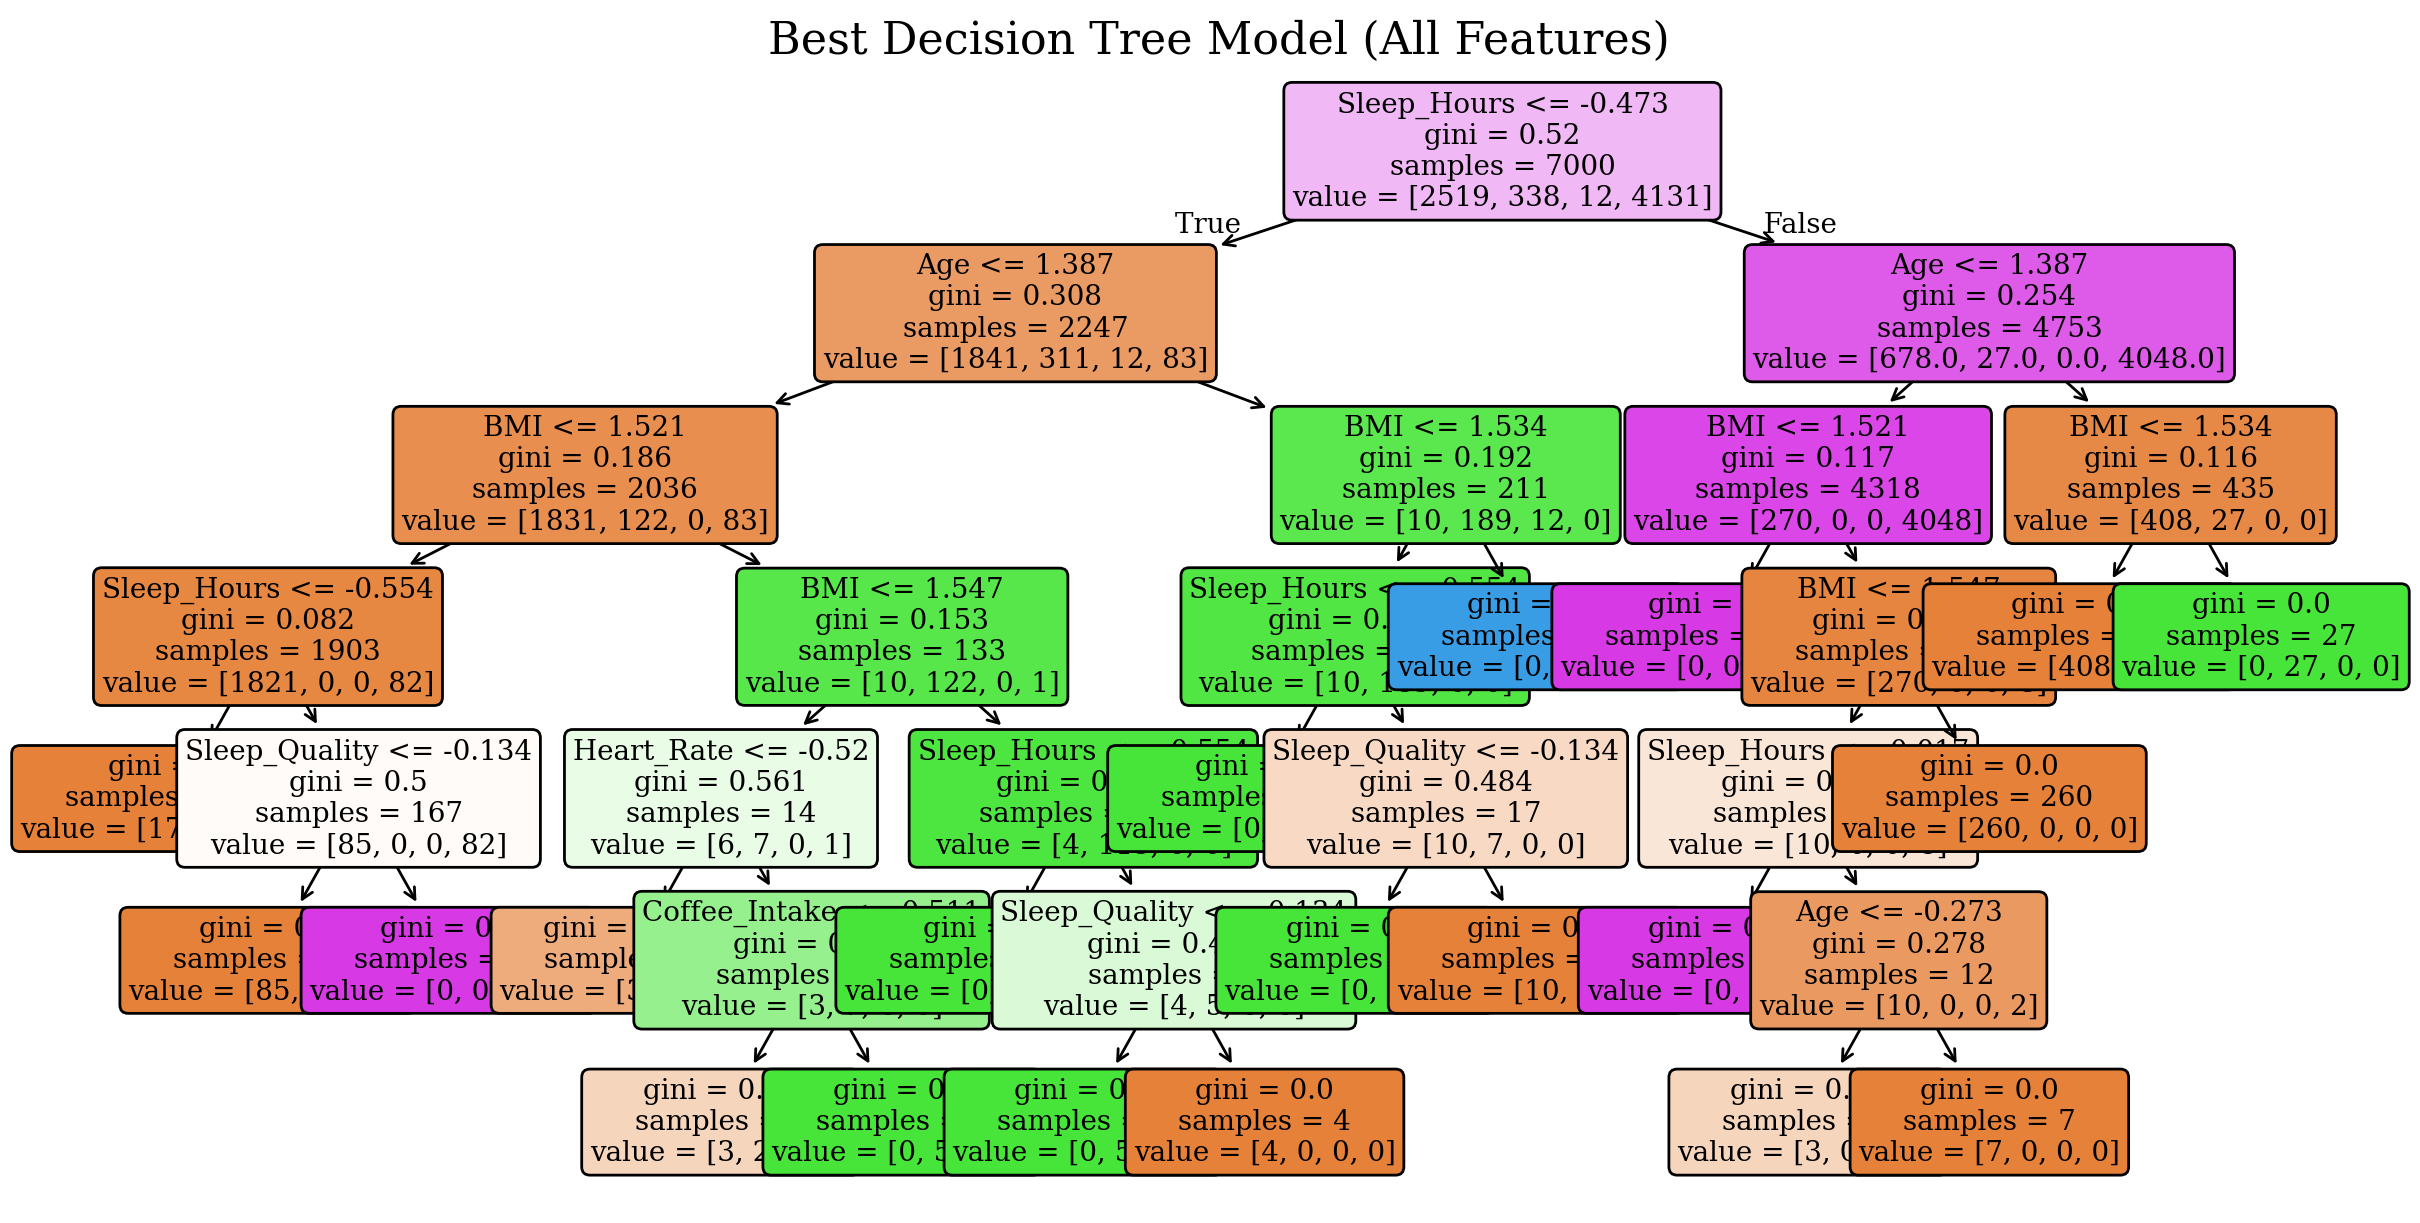

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1060
           1       1.00      0.99      1.00       125
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00      1810

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Confusion Matrix: 
 [[1060    0    0    0]
 [   1  124    0    0]
 [   0    0    5    0]
 [   3    0    0 1807]]


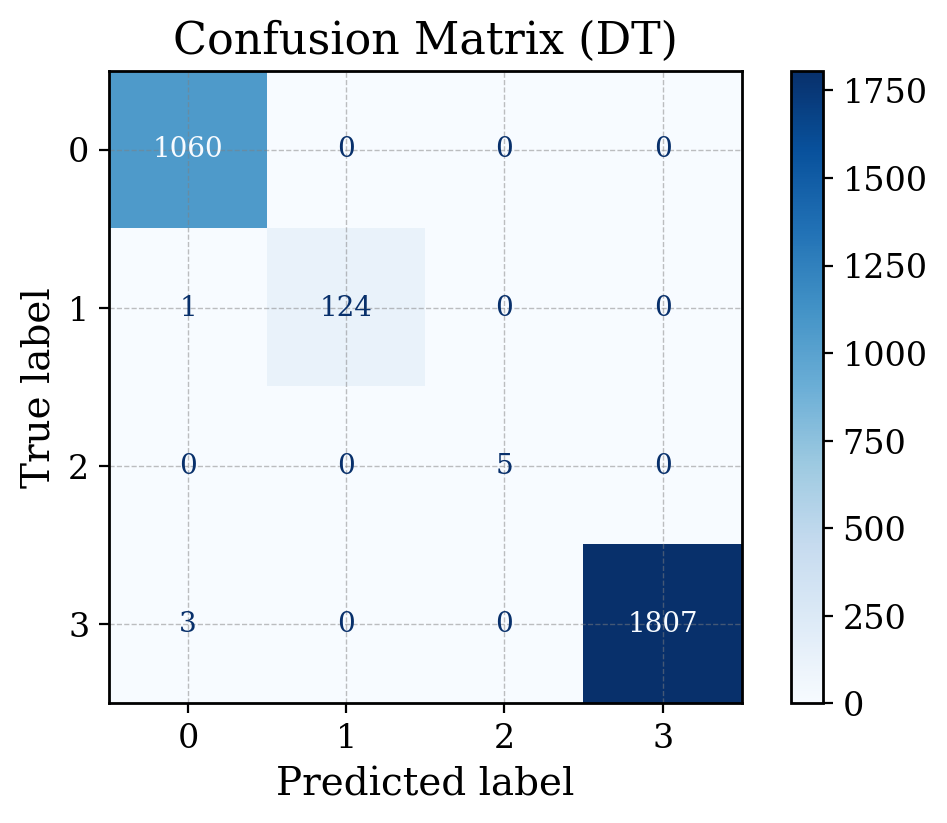

In [8]:
# Build pipeline
new_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('full_dt_regressor', DecisionTreeClassifier(random_state=42))  # Train Decision Tree Regressor
])

# Hyperparameter search space
param_distributions = {
    'full_dt_regressor__max_depth'        : randint(2, 10),
    'full_dt_regressor__min_samples_split': randint(2, 10),
    'full_dt_regressor__min_samples_leaf' : randint(1, 10)
}

# Randomized search with cross-validation
search = RandomizedSearchCV(
    estimator=new_pipeline,   # Use the new pipeline
    param_distributions=param_distributions, # Hyperparameter search space
    n_iter       = 30,    # Number of iterations for random search
    cv           = 10,     # Cross-validation folds
    scoring      = 'r2',  # Scoring metric for evaluation
    n_jobs       = -1,    # Use all available CPU cores
    random_state = 42,    # Random state for reproducibility
)

# Fit search
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict on validation set
y_pred = best_model.predict(X_val)

# Evaluation metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
ssr = np.sum((y_val - y_pred) ** 2)
r2 = r2_score(y_val, y_pred)

print("Best Parameters from RandomizedSearchCV:", search.best_params_)
print("Decision Tree regression metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SSR: {ssr:.4f}")
print(f"R2-score: {r2:.4f}")

# Cross-validation with best model
cv_scores = cross_val_score(best_model, X_val, y_val, cv=10, scoring='r2')
print(f"\nCross-Validated R2-Scores: {cv_scores}")
print(f"Average Cross-Validated R2: {cv_scores.mean():.4f}")

# Visualize the Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(best_model.named_steps['full_dt_regressor'], feature_names=train_df[feature_names].columns,
          filled=True,
          rounded=True,
          max_depth=10,  # You can remove or increase this if the tree is shallow
          fontsize=10)
plt.title("Best Decision Tree Model (All Features)")
plt.show()

print(classification_report(y_val,y_pred))

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", cm)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (DT)")
plt.show()    

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_63768/23222594.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(train_df.drop(columns="Health_Issues").columns, rotation=90)


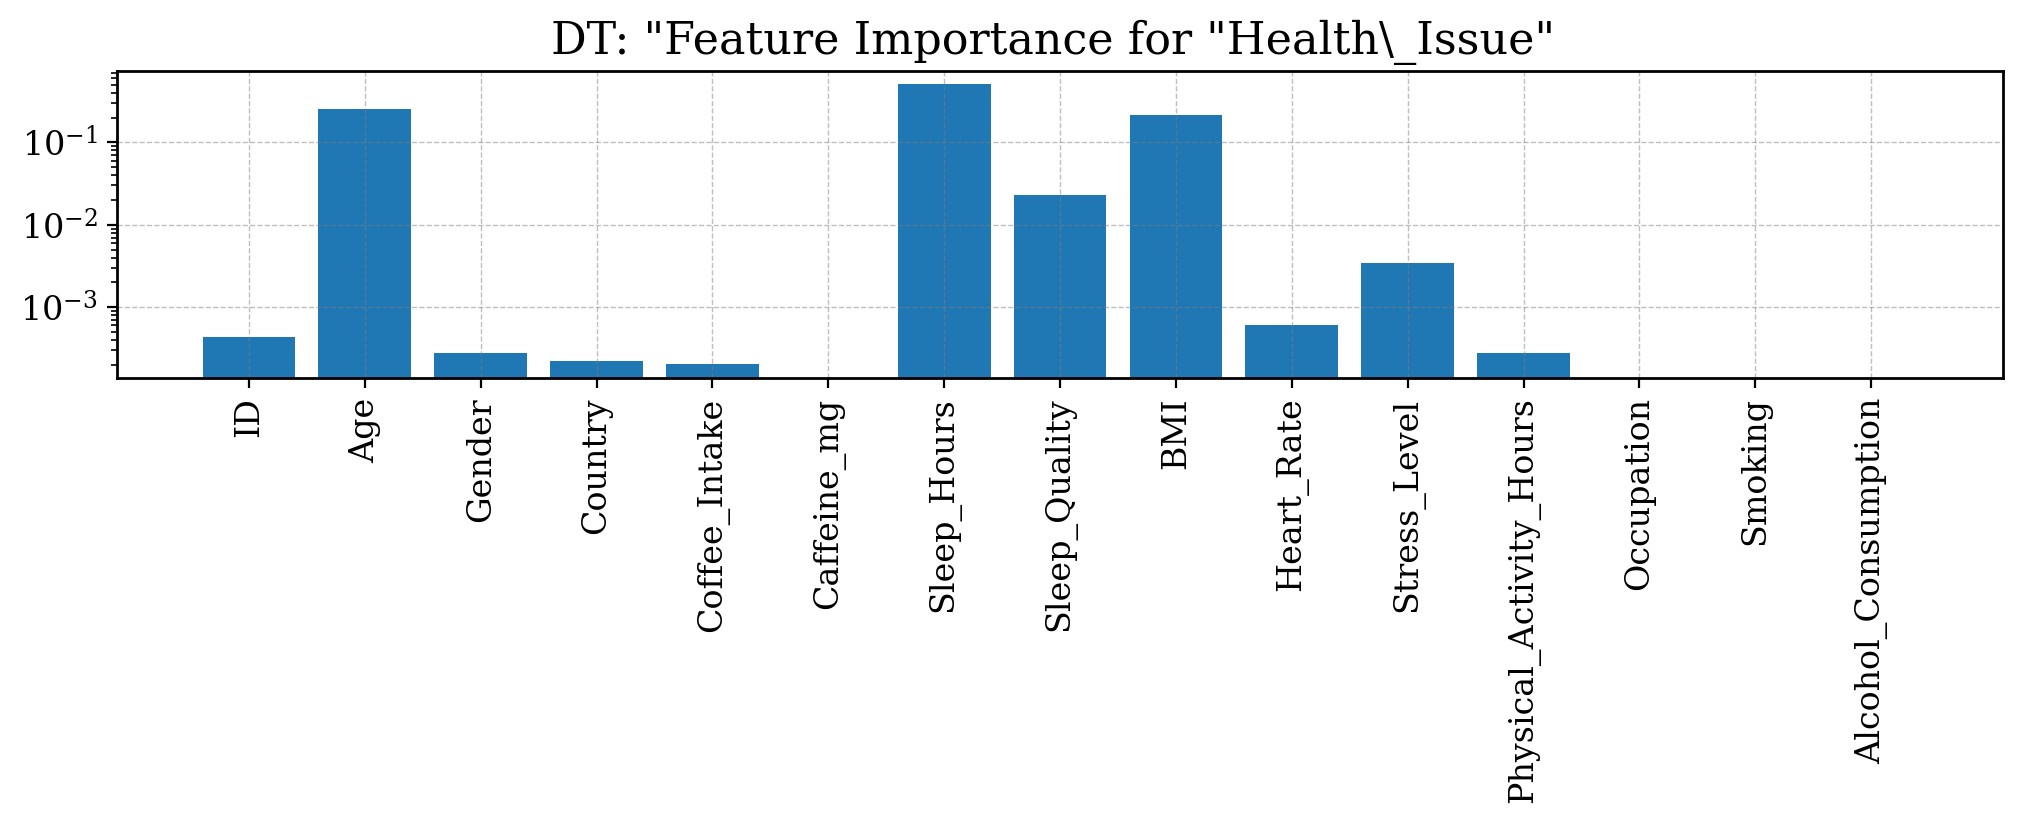

In [9]:
new_pipeline.fit(X_train, y_train)

hmm = new_pipeline.named_steps['full_dt_regressor'].feature_importances_

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(train_df.drop(columns="Health_Issues").columns,hmm,log=True)
ax.set_xticklabels(train_df.drop(columns="Health_Issues").columns, rotation=90)
plt.title("DT: \"Feature Importance for \"Health\_Issue\" ")
plt.show()

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_63768/2389977454.py:10: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


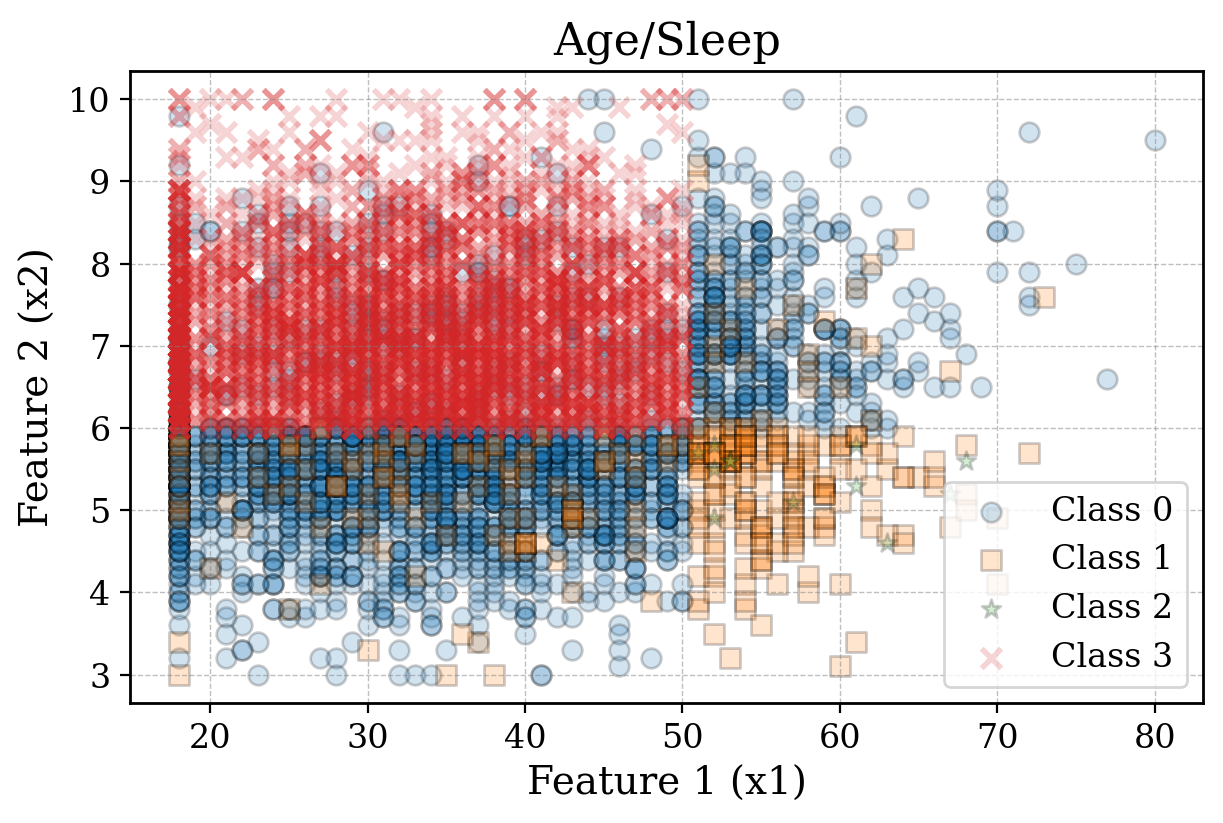

In [10]:
#KNN here for features Age/Sleep_Hours and label Health_Issues

X_train = train_df[["Age","Sleep_Hours"]].to_numpy()
y_train = train_df["Health_Issues"].to_numpy()

X_val = val_df[["Age","Sleep_Hours"]].to_numpy()
y_val = val_df["Health_Issues"].to_numpy()

visualize_data(X_train,y_train,"Age/Sleep")

/var/folders/rq/sf33k5wx73bcj8m51c786sc80000gn/T/ipykernel_63768/970715754.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


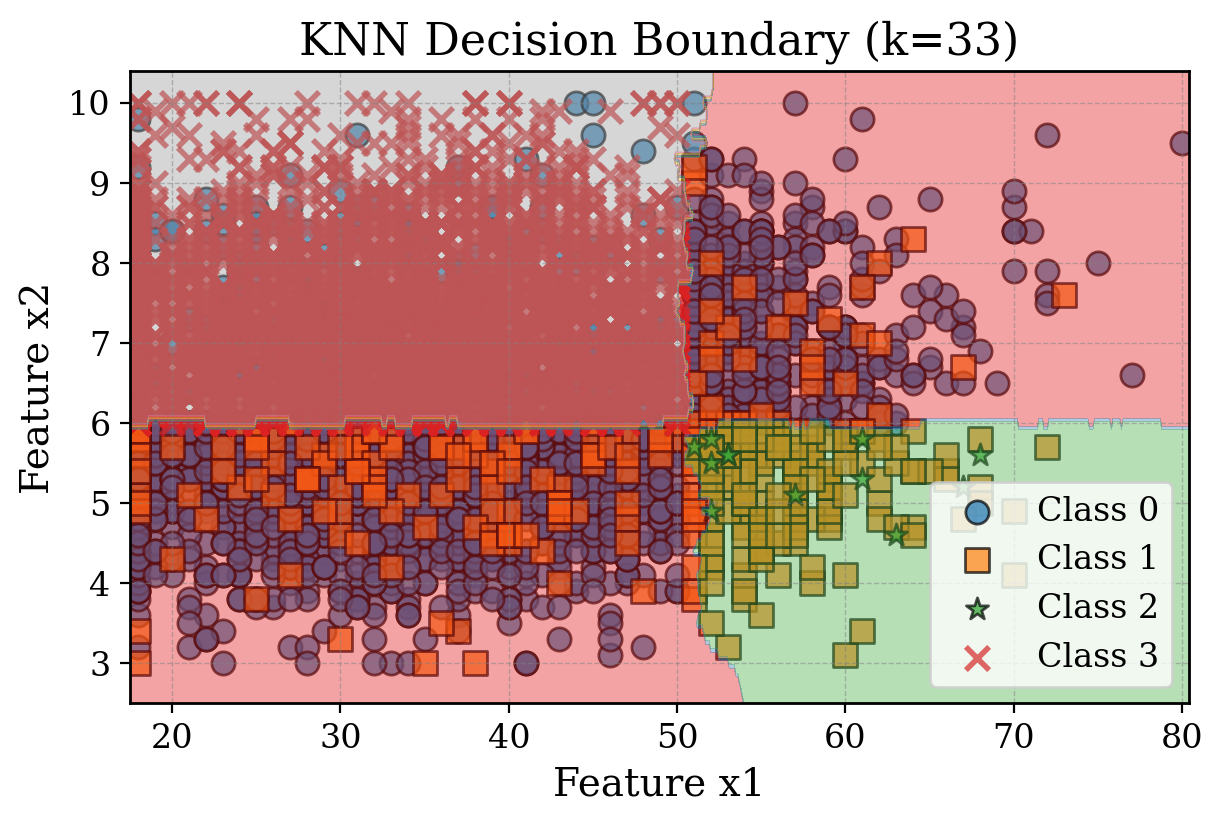

In [11]:
X = X_train.copy()

k = 33

# Train a KNN classifier
knn = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])

knn.fit(X_train, y_train)

# Create meshgrid for decision boundary
h = 0.1  # step size in the mesh
x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict on meshgrid
y_pred = knn.predict(np.c_[xx.ravel(), yy.ravel()])
y_pred = y_pred.reshape(xx.shape)

# Plot decision boundary
plt.figure()

# Plot each class dynamically
for i, class_label in enumerate(np.unique(y_train)):
    plt.scatter(
        X_train[y_train == class_label][:, 0], 
        X_train[y_train == class_label][:, 1],
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        s=70, edgecolor='k', alpha=0.7,
        label=f'Class {class_label}'
    )

plt.contourf(xx, yy, y_pred, alpha=0.4, cmap='Set1')

plt.xlabel('Feature x1')
plt.ylabel('Feature x2')
plt.title(f"KNN Decision Boundary (k={k})")
plt.legend()
plt.show()

In [12]:
hmm = list(range(1,101,2))
acc = []
for k in hmm:
    # Train a KNN classifier
    knn = Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k))
            ])

    knn.fit(X_train, y_train)

    # Predict
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    acc.append(accuracy)

#print(f'Model Accuracy: {accuracy:.2f}')

print(f'Best Model Accuracy: {max(acc):.2f} for k={2*np.argmax(acc)+1}')

Best Model Accuracy: 0.92 for k=33


Confusion Matrix: 
 [[ 927    2    0  131]
 [  67   58    0    0]
 [   1    4    0    0]
 [  28    0    0 1782]]


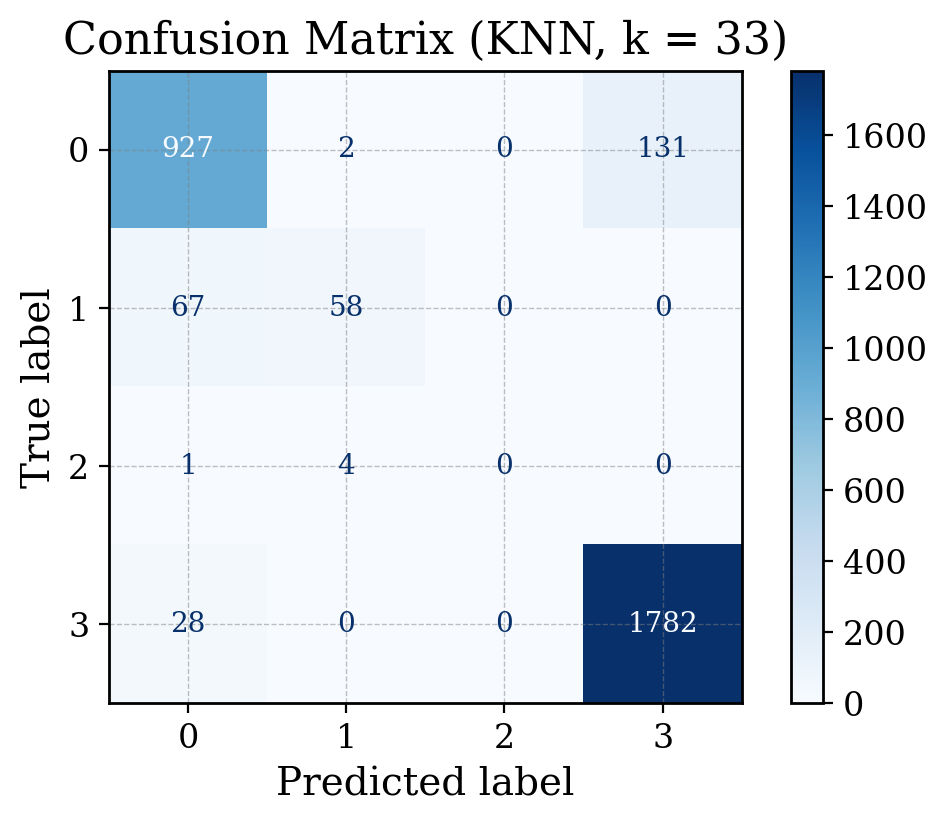

In [13]:
k = 33

# Train a KNN classifier
knn = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])

knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

# Print/plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", cm)
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (KNN, k = 33)")
plt.show()    

In [14]:
#Ensemble Learning: RandomForest/XGBoost with all features

# This class is designed to compare various classifiers on a given dataset.
class ClassifierComparison:
    def __init__(self, X, y, test_size=0.3, use_bootstrap=True, random_state=42):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)
        
        # Scale features
        scaler       = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test  = scaler.transform(X_test)

        # Take local copies for later use
        self.y_train = y_train
        self.y_test  = y_test
        self.use_bootstrap = use_bootstrap
        self.models     = {}
        self.results    = {}
        self.results_df = None

    def fit_models(self):
        # Define the classifiers to be compared
        self.models = {
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, bootstrap=self.use_bootstrap, random_state=42),
            'Bagging' : BaggingClassifier(n_estimators=100, bootstrap=self.use_bootstrap, random_state=42),
            'AdaBoost': AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'XGBoost' : XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42),
            'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
            'CatBoost': CatBoostClassifier(verbose=0, iterations=100, random_state=42)
        }

        results_list = [] # List to store results for DataFrame

        for name, model in self.models.items():
            # tic-toc the training and prediction time
            start_time_train = time.time()          # start the timer for training
            model.fit(self.X_train, self.y_train)   # train the model
            end_time_train = time.time()            # stop the timer for training
            
            start_time_pred = end_time_train        # start the timer for prediction
            y_pred = model.predict(self.X_test)     # make predictions
            end_time_pred = time.time()             # stop the timer for prediction

            # Calculate metrics and run time
            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Training Time (s)': (end_time_train - start_time_train),
                'Prediction Time (s)': (end_time_pred - start_time_pred),
                'Total Time (s)': (end_time_pred - start_time_train)
            }

            self.results[name] = {
                'model': model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            results_list.append(metrics)

        # Create a DataFrame from the results list
        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n")
        print("------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n")
        print("------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    def plot_confusion_matrices(self):
        for name, result in self.results.items():
            disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'])
            disp.plot()
            plt.title(f"Confusion Matrix: {name}")
            plt.show()

    # Plot decision boundaries for 2 features of different classifiers.
    # The default feature indices are (0, 1), but you can specify any two features.
    def plot_decision_boundaries(self, feature_indices=(0, 1)):
        i, j = feature_indices
        if self.X_train.shape[1] < 2:
            print("Decision boundary plot requires at least 2 features.")
            return

        h = 0.01
        x_min, x_max = self.X_train[:, i].min() - 0.5, self.X_train[:, i].max() + 0.5
        y_min, y_max = self.X_train[:, j].min() - 0.5, self.X_train[:, j].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        X_vis = np.zeros((xx.size, self.X_train.shape[1]))
        X_vis[:, i] = xx.ravel()
        X_vis[:, j] = yy.ravel()

        for name, result in self.results.items():
            model = result['model']
            # Predict the decision boundary. 
            # We use try-except to handle any potential errors during prediction.
            # Google the "try-except" in Python and learn it.
            try:
                prd = model.predict(X_vis)
                prd = prd.reshape(xx.shape)
                
                # Create a colormap for the regions
                region_cmap = ListedColormap(colors[:len(np.unique(self.y_train))])
                point_colors = np.array(colors)[self.y_train]

                plt.figure()
                plt.contourf(xx, yy, prd, alpha=0.3, cmap=region_cmap)
                plt.scatter(self.X_train[:, i], self.X_train[:, j],
                            c=point_colors, edgecolor='k', s=40, alpha=0.8)
                plt.xlabel("$x_{i}$", fontsize=14)
                plt.ylabel("$x_{j}$", fontsize=14)
                plt.title(f"Decision Boundary: {name} (Features x{i} vs x{j})")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.show()
            except Exception as e:
                print(f"Skipping {name}: failed to predict decision boundary. Error: {e}")

In [15]:
# Create an instance of ClassifierComparison and fit the models

feature_names = train_df.select_dtypes(include=["number"]).drop(columns=["Health_Issues"]).columns

X_train = train_df[feature_names].values  # Exclude "Gain" from training features
y_train = train_df["Health_Issues"].values  # Target variable

X_val = val_df[feature_names].values  # Exclude "Gain" from validation features
y_val = val_df["Health_Issues"].values  # Target variable

clf = ClassifierComparison(X_train, y_train)
clf.fit_models()

/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 4900, number of used features: 15
[LightGBM] [Info] Start training from score -1.022218
[LightGBM] [Info] Start training from score -3.028930
[LightGBM] [Info] Start training from score -6.417549
[LightGBM] [Info] Start training from score -0.527287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [16]:
clf.print_summary()



------ Results Sorted by Accuracy ------
            Model  Accuracy  Precision   Recall  F1 Score  Training Time (s)  Prediction Time (s)  Total Time (s)
    Decision Tree  0.997619   0.997617 0.997619  0.997612           0.007496             0.000125        0.007621
          Bagging  0.997143   0.997141 0.997143  0.997129           0.546545             0.008320        0.554865
Gradient Boosting  0.997143   0.997141 0.997143  0.997105           2.178009             0.005098        2.183107
         CatBoost  0.997143   0.997141 0.997143  0.997129           0.207060             0.004396        0.211456
          XGBoost  0.996667   0.996660 0.996667  0.996622           0.062259             0.001412        0.063671
         LightGBM  0.996190   0.996203 0.996190  0.996035           0.188570             0.008522        0.197092
    Random Forest  0.995238   0.995225 0.995238  0.994785           0.243547             0.008089        0.251636
         AdaBoost  0.406190   0.182339 0.4061

In [17]:
class ClassifierComparisonOpt:
    def __init__(self, X, y, test_size=0.3, use_bootstrap=True, random_state=42, cv_folds=5):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)

        # Scale features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test  = scaler.transform(X_test)

        self.y_train       = y_train
        self.y_test        = y_test
        self.use_bootstrap = use_bootstrap
        self.cv_folds      = cv_folds
        self.models        = {}
        self.results       = {}
        self.results_df    = None

    # Define the classifiers and their hyperparameters
    def get_models_with_params(self):
        return {
            'Decision Tree': (DecisionTreeClassifier(random_state=42), {
                'max_depth': [None, 3, 5, 10, 20],
                'min_samples_split': [2, 5, 7, 10]
            }),
            'Random Forest': (RandomForestClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 3, 5, 10, 20],
                'min_samples_split': [2, 5, 7, 10]
            }),
            'Bagging': (BaggingClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_samples': [0.5, 1.0],
                'oob_score': [True, False],
            }),
            # SAMME: Stagewise Additive Modeling using a Multi-class Exponential loss
            'AdaBoost': (AdaBoostClassifier(algorithm='SAMME', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
            }),
            'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            }),
            'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            }),
            #'LightGBM': (LGBMClassifier(random_state=42), {
            #    'n_estimators': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'max_depth': [-1, 5, 10]
            #}),
            #'CatBoost': (CatBoostClassifier(verbose=0, random_state=42), {
            #    'iterations': [50, 100, 200],
            #    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
            #    'depth': [4, 6, 10]
            #})
        }

    def fit_models(self):
        results_list = []
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        models_with_params = self.get_models_with_params()

        for name, (model, param_grid) in models_with_params.items():
            print(f"Tuning {name} ...")
            
            grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
            
            start_train = time.time()
            grid_search.fit(self.X_train, self.y_train)
            end_train = time.time()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            end_pred = time.time()

            self.models[name] = {
                'model': best_model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Best Params': grid_search.best_params_,
                'Training Time (s)': (end_train - start_train),
                'Prediction Time (s)': (end_pred - end_train),
                'Total Time (s)': (end_pred - start_train)
            }

            results_list.append(metrics)

        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    # Show feature importance for models that support it          
    def show_feature_importance(self):
        importance = {}

        for name, result in self.models.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance[name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                coef = model.coef_
                if coef.ndim == 1:
                    importance[name] = np.abs(coef)
                else:
                    importance[name] = np.mean(np.abs(coef), axis=0)
            else:
                print(f"Feature importance not available for model {name}")

        for name, imp in importance.items():
            sorted_idx = np.argsort(imp)[::-1]
            plt.figure()
            plt.bar(range(len(imp)), imp[sorted_idx], align='center')
            plt.xticks(range(len(imp)), sorted_idx)
            plt.title(f"Feature importance for {name}")
            plt.xlabel("Feature index")
            plt.ylabel("Importance score")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

clf_opt = ClassifierComparisonOpt(X_train, y_train)
clf_opt.fit_models()

Tuning Decision Tree ...
Tuning Random Forest ...
Tuning Bagging ...
Tuning AdaBoost ...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorith

Tuning Gradient Boosting ...
Tuning XGBoost ...


In [18]:
# Print the summary of results
clf_opt.print_summary()


------ Results Sorted by Accuracy ------
            Model  Accuracy  Precision   Recall  F1 Score                                                    Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
    Decision Tree  0.997619   0.997617 0.997619  0.997612                    {'max_depth': None, 'min_samples_split': 2}           0.146188             0.000117        0.146305
          Bagging  0.997143   0.997141 0.997143  0.997129    {'max_samples': 1.0, 'n_estimators': 50, 'oob_score': True}           4.272999             0.004271        4.277270
Gradient Boosting  0.997143   0.997141 0.997143  0.997105    {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}          58.736457             0.005388       58.741845
          XGBoost  0.997143   0.997141 0.997143  0.997105    {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}           2.875356             0.001252        2.876608
    Random Forest  0.994762   0.994743 0.994762  0.994295 {'max_depth': 2

Feature importance not available for model Bagging


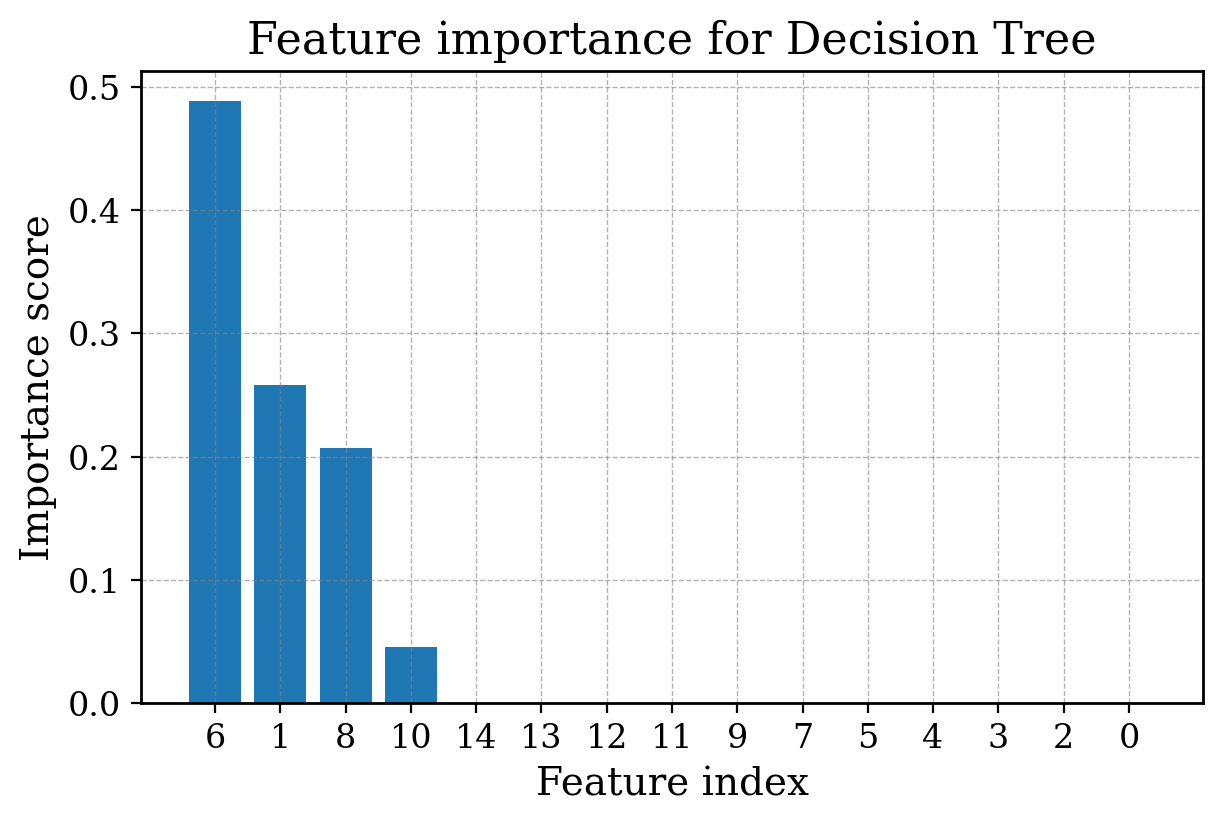

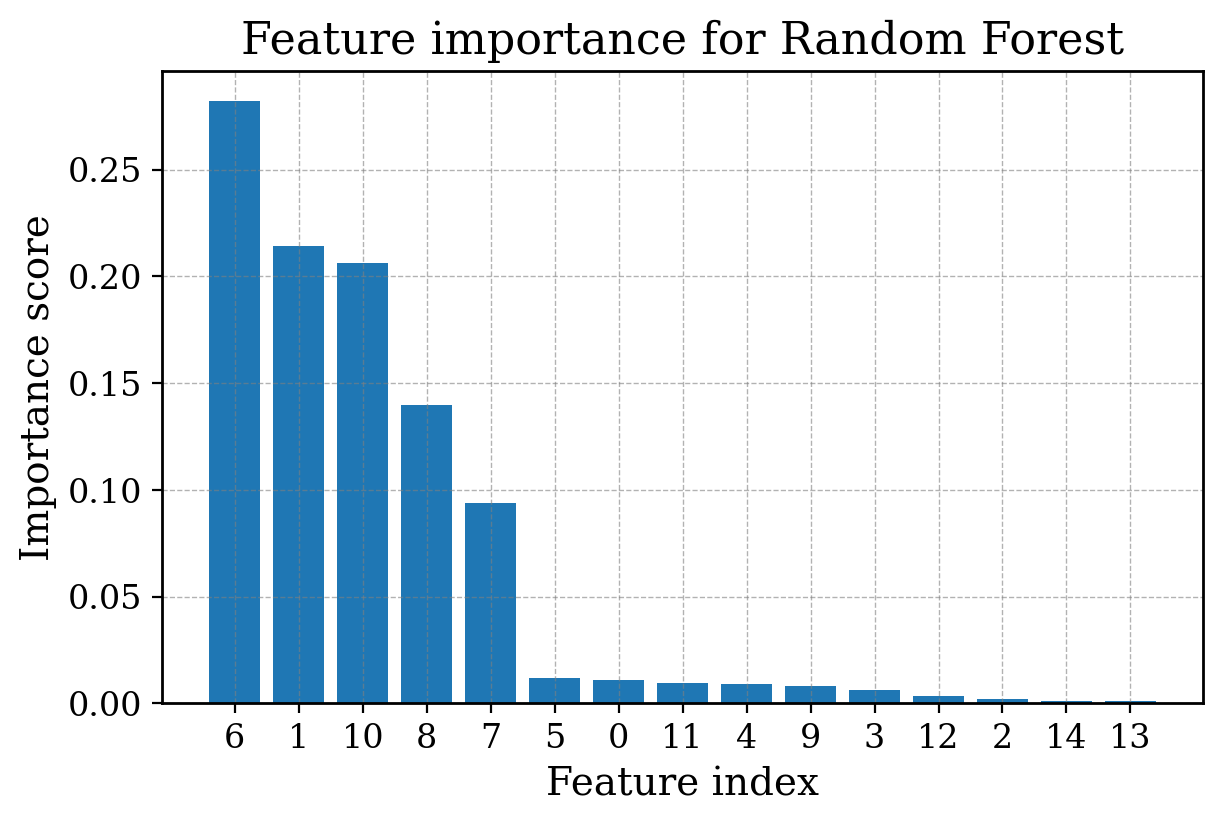

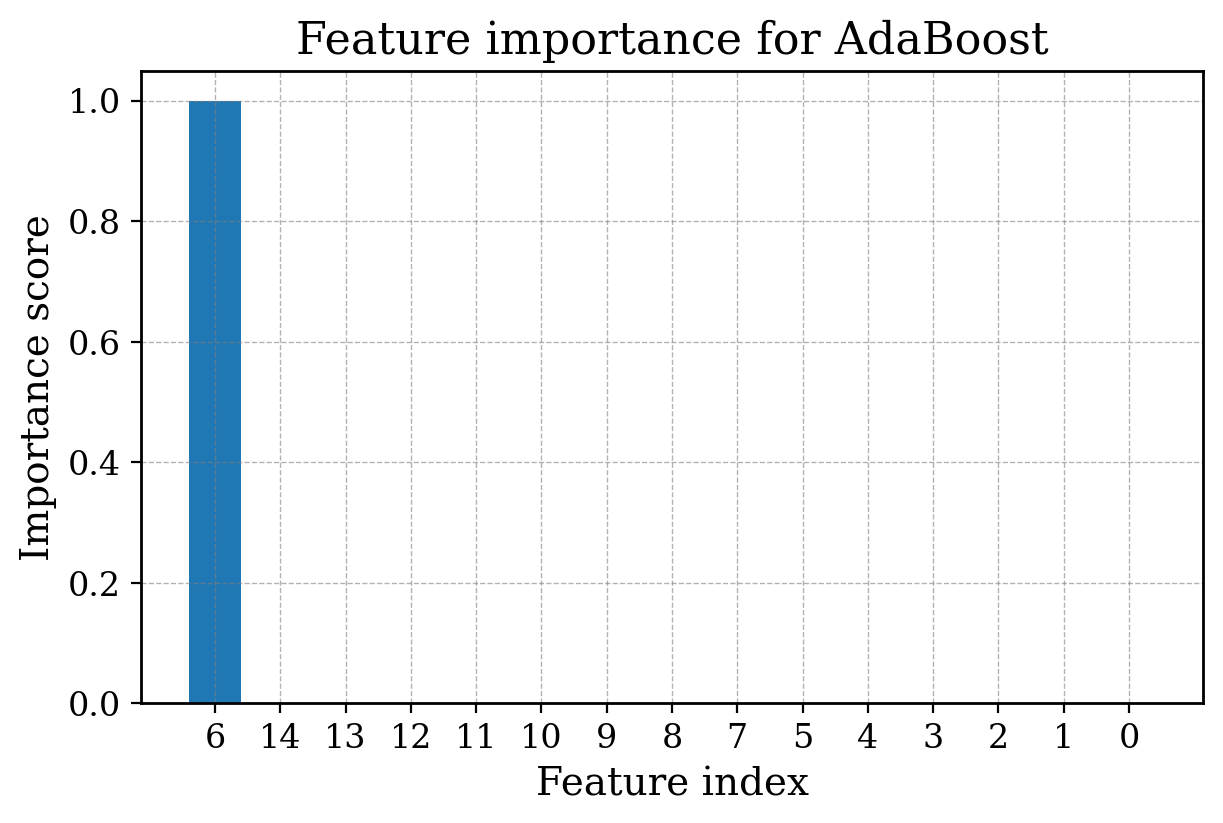

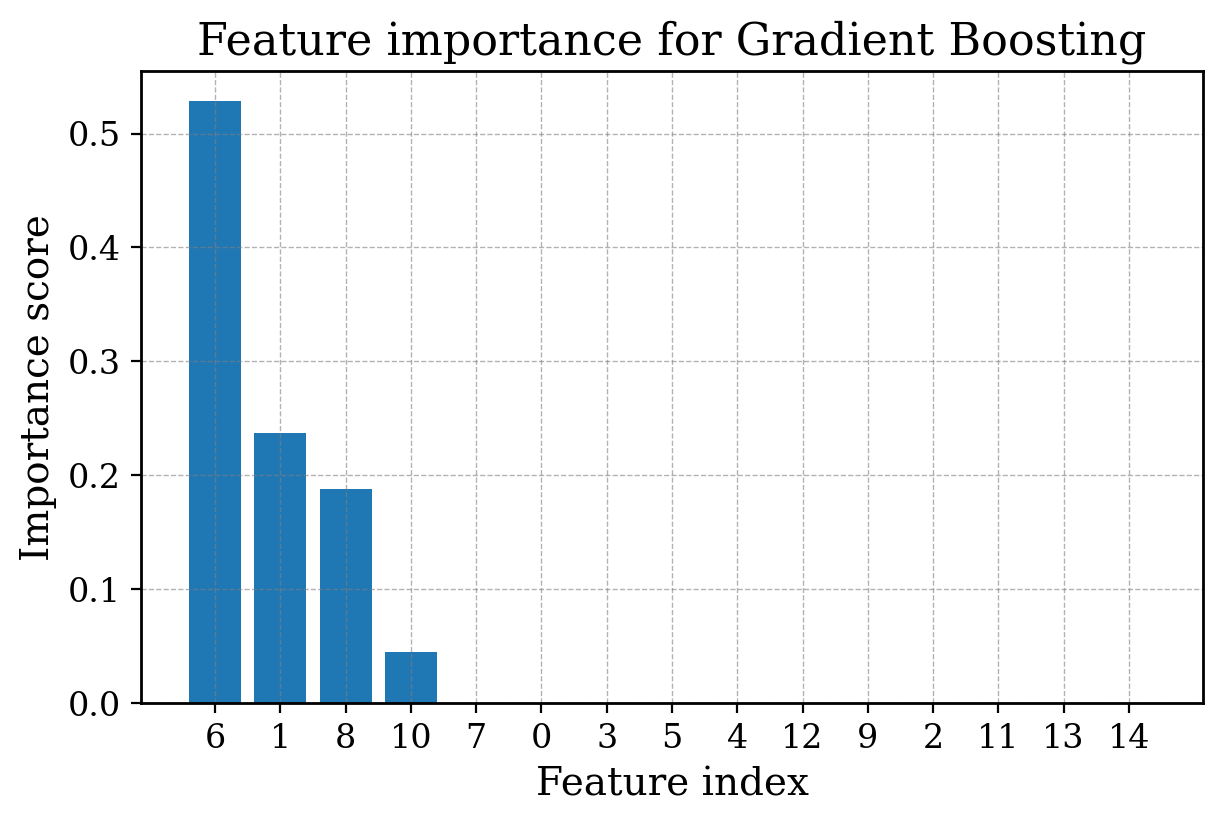

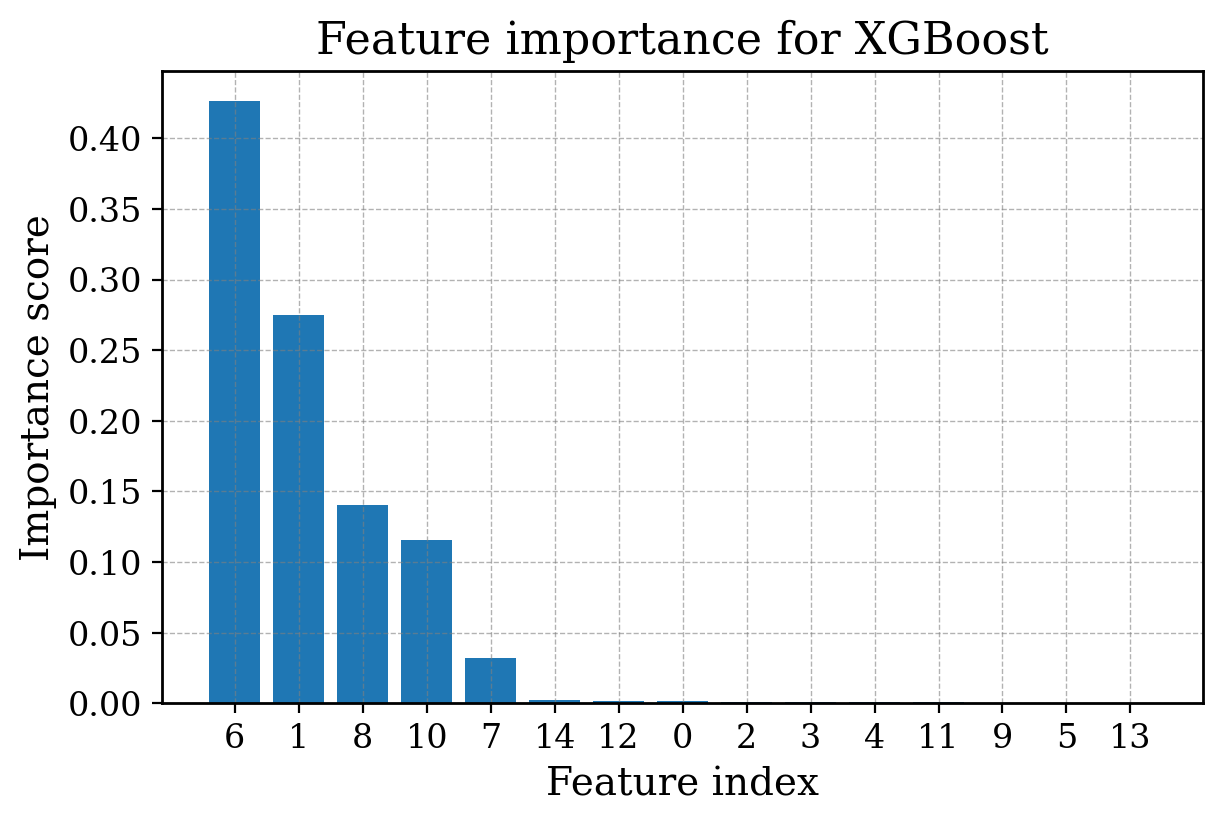

Exception ignored in: <function ResourceTracker.__del__ at 0x1085e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105a95bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107a65bc0>
Traceback (most recent call last

In [ ]:
# Show feature importance for each model
clf_opt.show_feature_importance()